<a target="_blank" href="https://colab.research.google.com/github/SLCFLAB/Fintech2025-2/blob/main/ML_day2/2_4_ConfusionMatrix.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ML_Day2_2

ref: https://github.com/codingalzi/handson-ml2/blob/master/notebooks/handson-ml2-03.ipynb

## 주요내용

* 분류 모델 성능 평가 방법 소개
* 실전 예제: MNIST 데이터셋을 이용한 숫자 이미지 분류

## 기본 설정

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
# 어레이 데이터를 csv 파일로 저장하기
def save_data(fileName, arrayName, header=''):
    np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')    

## MNIST 데이터를 활용한 분류 성능 평가 예시

#### 데이터 불러오기

MNIST 데이터셋을 가져온다.
`fetch_openml()` 함수의 반환값은 사전 자료형을 살짝 확장한 `Bunch` 객체이며,
기본적으로 `dictionary` 자료형처럼 사용하면 된다.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [3]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

처음 100개의 이미지는 다음과 같다.

In [4]:
X, y = mnist["data"], mnist["target"]

그림 저장: more_digits_plot


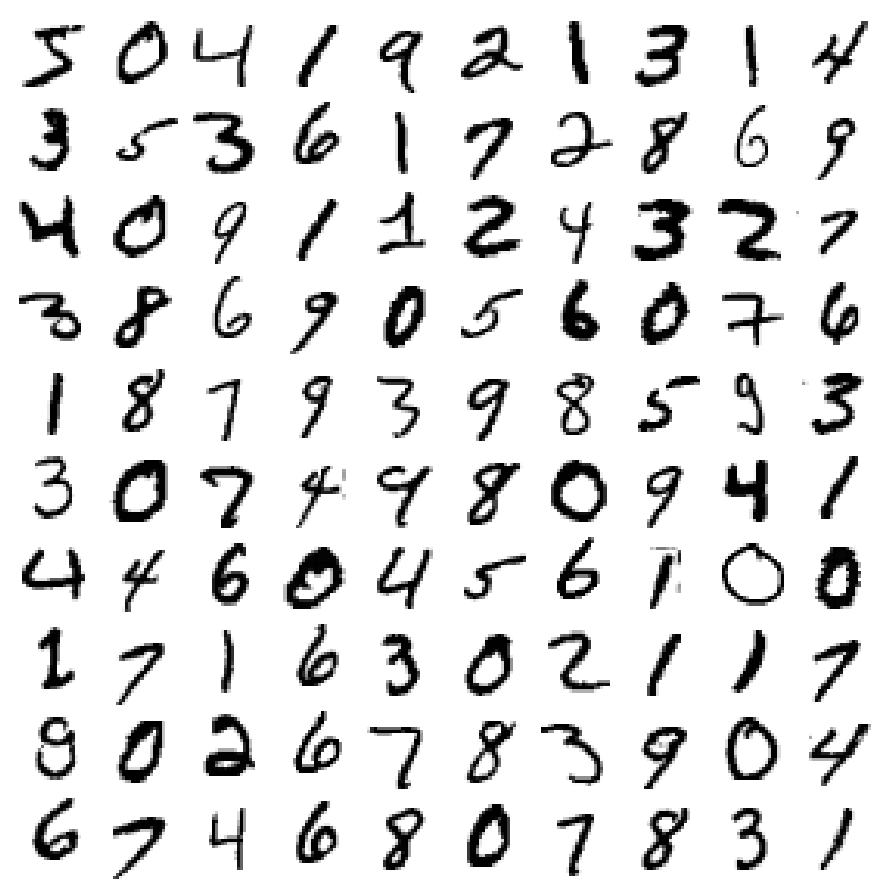

In [5]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

#### 훈련 세트와 테스트 세트로 분류

처음 60,000개의 샘플은 훈련 세트로, 이후 10,000개의 샘플은 테스트 세트로 이미 
계층별 샘플링 방식으로 구분되어 있다.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train

array(['5', '0', '4', ..., '5', '6', '8'], dtype=object)

### 이진 분류기 훈련

이미지가 숫자 5를 표현하는지 여부만을 판단하는 이진 분류기의 훈련을 위해 레이블을 0 또는 1로 변경한다.
* 0: 숫자 5 아님.
* 1: 숫자 5 맞음.

In [8]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

확률적 경사 하강법(SGD) 분류기를 훈련시키기 위해 `fit()` 메서드를 호출한다.
* `max_iter=1000`: 훈련 데이터를 최대 1000번 반복해서 학습에 사용함. 
* `tol=le-3`: 전체 훈련 세트를 한 번 학습할 때마다 성능 향상이 연속적으로 지정된 값 이상으로 이루어지지 않을 때 학습을 멈추도록 하는 데에 사용됨. 
기본적으로 5번 이상 성능 향상이 10의 -3승 이상 이루어지지 않으면 학습을 강제로 멈춤.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

첫째 샘플의 예측값은 `True`, 즉, 숫자 5라고 정확하게 맞춘다.

In [10]:
some_digit = X[0] #예시 이미지 샘플

sgd_clf.predict([some_digit])

array([ True])

## 분류 성능 평가

분류기 성능을 측정하는 세 가지 방법을 소개한다.

* 교차 검증을 활용한 정확도 측정
* 정밀도/재현율 조율
* AUC 측정

### 교차 검증을 사용한 정확도 측정

분류기의 정확도 평가는 실제 일반화 성능을 평가하기 위해 교차 검증(cross validation)을 이용한다.

아래 코드는 3겹 교차 검증(3-fold cross validation)을 실행한다.
결과는 정확도 95% 이상이다.

* `cv=3`: 폴더 3개 사용
* `scoring="accuracy"`: 정확도 검증

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # 모델이 분류기(y가 class)인 경우, 자동으로 stratified k-fold CV를 수행함.

array([0.95035, 0.96035, 0.9604 ])

### 참고사항

성능 평가 점수 등이 조금 달라질 수 있지만, 어떤 문제가 있는 것은 아니다. 
결과가 조금씩 달라지는 이유는 아래와 같다.

* 첫째, 사이킷런과 다른 라이브러리들이 발전하면서 알고리즘이 조금씩 변경되기 때문에 얻어지는 결괏값이 바뀔 수 있다. 
* 둘째, 많은 훈련 알고리즘이 확률적, 즉 무작위성에 의존한다. 
    이론적으로 `random_state=42`나 `np.random.seed(42)` 등
    난수 생성기에 시드를 지정하여 일관된 결과를 얻을 수 있지만 항상 보장되지는 않는다. 
* 셋째, 훈련 알고리즘이 여러 스레드(C로 구현된 알고리즘)나 여러 프로세스(예를 들어 n_jobs 매개변수를 사용할 때)로 
    실행되면 연산이 실행되는 정확한 순서가 항상 보장되지 않으며, 따라서 결괏값이 조금 다를 수 있다.
* 넷째, 파이썬 사전(dict)이나 셋(set) 객체는 항목을 사용하는 순서가 경우에 따라 달라질 수 있다.

### 오차 행렬

교차 검증을 이용하여 각 fold에 대해 평가 점수를 바로 계산하는 대신에 예측(분류)을 수행할 수 있다.

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`confusion_matrix()` 함수가 오차 행렬을 만들어준다.

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)

cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

위 결과는 다음을 보여준다.

```
TN | FP
---|---
FN | TP
```

* TN: 참 음성 개수. 즉, 5가 아닌 이미지를 5가 아니라고 정확하게 예측한 경우의 수
* FP: 거짓 양성 개수. 즉, 5가 아닌 이미지를 5라고 잘못 예측한 경우의 수
* FN: 거짓 음성 개수. 즉, 5를 나타내는 이미지를 5가 아니라고 잘못 예측한 경우의 수
* TP: 참 양성 개수. 즉, 5를 나타내는 이미지를 5라고 정확하게 예측한 경우의 수

__참고:__ 완벽한 이진 분류기의 오차 행렬은 대각선 이외의 값이 모두 0인 대각 행렬이다.

In [14]:
y_train_perfect_predictions = y_train_5  # 예측값을 실제 레이블로 지정. 즉, 완벽한 분류 결과로 사용
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 정밀도(precision)와 재현율(recall)

#### 이진 분류기의 정밀도

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

수동으로 정밀도 계산:

$$
\text{정밀도} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

In [16]:
#confusion matrix에서 정밀도 계산
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

#### 이진 분류기의 재현율

In [17]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

수동으로 재현율 계산:

$$
\text{재현율} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

In [18]:
#confusion matrix에서 재현율 계산
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

#### F<sub>1</sub> 점수 계산

정밀도와 재현율의 조화평균을 F<sub>1</sub> 점수라 한다.
precision, recall 간 trade-off를 고려한 점수

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

수동으로 F<sub>1</sub> 점수 계산:

$$
F_1 
= \frac{2}{\frac{1}{\text{정밀도}} + \frac{1}{\text{재현율}}}
= \frac{\text{TP}}{\text{TP} + \frac{\text{FN} + \text{FP}}{2}}
$$

In [20]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

### 정밀도/재현율 트레이드오프

#### 샘플 점수

SGD 분류기는 `decision_function()`을 이용하여 예측에 필요한 점수를 각 샘플에 대해 계산한다.
예를 들어, 첫째 샘플의 점수는 아래와 같다.

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

예측한 점수가 지정된 임계갓보다 크면 양성, 즉 `True`로 판정한다.
아래 코드는 임곗값을 0으로 지정한 결과를 보여준다.

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [23]:
y_some_digit_pred

array([ True])

임곗값을 변경하면 예측값이 달라질 수 있다.
아래 코드는 임곗값을 8000으로 할 때, 첫째 샘플에 대한 예측값이 `False`로 변경되는 것을 보여준다.

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

#### 임곗값 활용

사이킷런에서 임곗값을 임의로 직접 지정할 수는 없다. 
하지만 임곗값을 수동으로 변경하면서 정밀도와 재현율의 관계를 확인한 다음에 
목적에 따라 가장 적절한 임곗값을 찾을 수 있다.

먼저, 교차 검증을 이용하여 모든 훈련 샘플에 대한 예측 점수를 확인한다.

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

`precision_recall_curve()` 함수는 가능한 모든 임곗값에 대한 정밀도와 재현율을 계산한 값을 반환한다.

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#### 임곗값, 정밀도, 재현율 그래프

임곗값을 기준으로 정밀도와 재현율의 변화를 그래프로 그리면 다음과 같다.
빨강 점들과 연결된 빨강 점선은 정밀도가 90%가 되는 지점의 정밀도와 재현율을 보여준다.

__주의사항:__ 정밀도와 재현율을 담은 어레이의 마지막 항목은 각각 1과 0이며, 이는 기술적인 이유때문에 추가되었다.
따라서 임곗값 어레이의 길이와 맞추기 위해 정밀도와 재현율의 어레이에서 마지막 항목은 무시해야 한다.

그림 저장: precision_recall_vs_threshold_plot


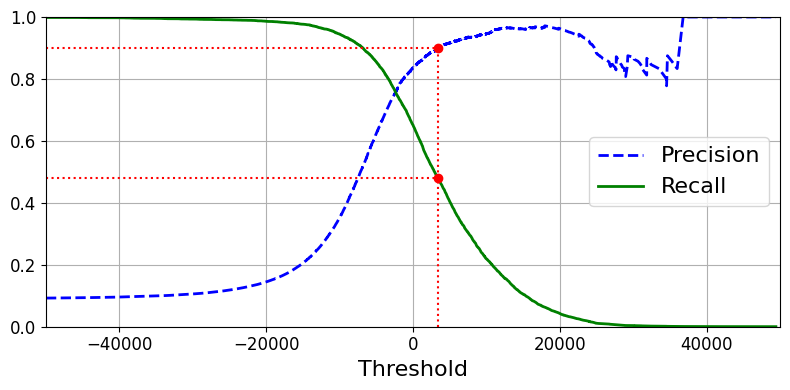

In [27]:
# 정밀도와 재현율 그래프 그리기. x 축은 임곗값을 가리킴.
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) # 정밀도 어레이 마지막 항목 무시
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)        # 재현율 어레이 마지막 항목 무시
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])            

# 정밀도 90%가 달성되는 지점에서의 재현율과 임곗값
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# 빨강 점과 빨강 점선 그리기
plt.figure(figsize=(8, 4))                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  # 수직 빨강 점선
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                 # 위 수평 빨강 점선
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")  # 아래 수평 빨강 점선
plt.plot([threshold_90_precision], [0.9], "ro")                              # 위 빨강 점 
plt.plot([threshold_90_precision], [recall_90_precision], "ro")              # 아래 빨강 점

save_fig("precision_recall_vs_threshold_plot")                                
plt.show()

재현율 그래프와는 달리 정밀도 그래프는 100% 근처에서 상승과 하강이 살짝 이루지도 한다.

이유는 임곗값을 올리면서 양성으로 판명된 샘플의 수는 기본적으로 줄어들지만 거짓 양성 샘플 수(FP)는 
순간적으로는 변하지 않을 수도 있기 때문이다. 

반면에 재현율은 전체 양성 샘플 수를 대상으로 하기에 그래프의 진동이 발생하지 않는다.

### ROC 곡선

__수신기 조작 특성__(Receiver Operating Characteristic, ROC)을 그려서 분류기의 성능을 측정할 수 있다.

여기서 사용되는 기준은 재현율과 정밀도의 관계가 아니라
__참 양성 비율__(true positive rate, TPR)과 
__거짓 양성 비율__(false positive rate, FPR) 사이의 관계이다. 

TPR은 재현율(recall)의 다른 명칭이며, FPR은 실제로 음성에 속하는 샘플 중에서 양성으로 잘못 판정되는 경우의 비율이다. 

```
TN | FP
---|---
FN | TP
```

$$
\text{TPR} = \frac{\text{TP}}{\text{FN} + \text{TP}} \qquad
\text{FPR} = \frac{\text{FP}}{\text{TN} + \text{FP}}
$$

앞서 정밀도와 재현율의 관계를 그래프로 묘사한 것과 비슷한 방식으로
TPR와 FPR 사이의 관계를 그래프로 그리면 다음과 같다.

* `roc_curve()` 함수: 임곗값의 변화에 따른 TPR, FPR 계산. 
    `precision_recall_curve()` 함수와 유사한 기능 제공.

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


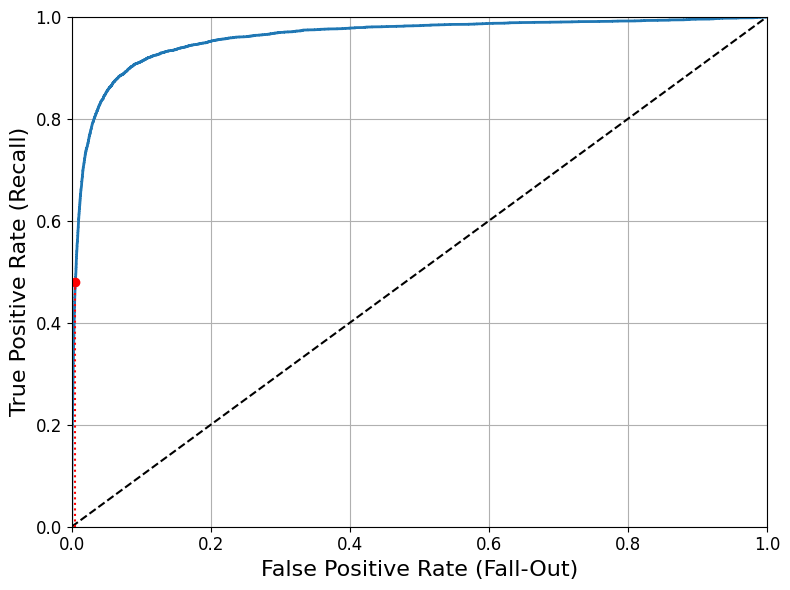

In [29]:
# SGD 분류기 모델의 TPR과 FPR 사이의 관계 그래프 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)

# 정밀도가 90%를 넘어설 때의 재현율(TPR, 참 양성 비율)에 해당하는 거짓 양성 비율(FPR)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]   # 0.0053 정도         
# 빨강 점과 원점 사이의 실선 그리기
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # 수직 빨강 점선. 좌표는 (0.0053, 0.48) 정도
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # y축과 빨강 점 사이의 수평 빨강 점선(거의 안보임))
plt.plot([fpr_90], [recall_90_precision], "ro")               # 빨강 점
save_fig("roc_curve_plot")                                  
plt.show()

TPR이 증가하면 FPR도 증가한다.

따라서 거짓 양성 비율을 최대한 낮추면서 재현율을 최대한 높일 수 있는 모델이 좋은 모델이다.

이를 계량화 화면, ROC 곡선의 아랫쪽의 면적인 __AUC__(area under curve)가 1에 가깝게 
나오도록 해주는 모델이 좋은 모델이다. 

SGD 분류기의 AUC는 0.96 정도이다.

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### 결정 경계

붓꽃(iris) 데이터셋을 이용하여 로지스틱 회귀를 이용한 분류에 활용되는 결정 경계를 설명한다.
아래 코드는 사이킷런에서 제공하는 붓꽃 데이터셋을 번치(Bunch) 자료형으로 불러온다. 

__참고:__ `Bunch` 자료형은 기본적으로 `dict` 자료형과 동일하다. 
차이점은 인덱싱을 속성(attribute)처럼 처리할 수 있다는 것 뿐이다.

In [31]:
from sklearn import datasets
iris = datasets.load_iris()

데이터셋에 사용된 키는 다음과 같다. 

In [32]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

`'data'` 키에 해당하는 값은 (150, 4) 모양의 넘파이 어레이다.

- 150: 150개의 붓꽃 샘플
- 4: 네 개의 특성. 차례대로 꽃받침 길이, 꽃받침 너비, 꽃잎 길이, 꽃잎 너비.

아래 코드는 처음 5개의 샘플 데이터를 보여준다. 

__참고:__ 원래 `iris['data'][:5]`로 값을 확인하지만 `Bunch` 자료형이기에 아래와 같이 클래스의
속성 형식으로 확인할 수도 있다. 인용부호를 사용하지 않음에 주의해야 한다.

In [33]:
iris.data[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

`'target'` 키는 150개 붓꽃에 대한 품종을 1차원 어레이로 담고 있다.

- 0: 세토사(Iris-Setosa)
- 1: 버시컬러(Iris-Versicolor)
- 2: 버지니카(Iris-Virginica)

언급된 순서대로 50개씩 세 품종의 타깃이 저장되어 있으며, 
처음 5개의 샘플은 세토사 품종임을 아래처럼 확인할 수 있다.

In [34]:
iris.target[:5]

array([0, 0, 0, 0, 0])

50번 인덱스부터는 버시컬러 품종이다.

In [35]:
iris.target[50:55]

array([1, 1, 1, 1, 1])

100번 인덱스부터는 버지니카 품종이다.

In [36]:
iris.target[100:105]

array([2, 2, 2, 2, 2])

이런 정보가 `'DESCR'` 속성에 저장되어 있다.

In [37]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

#### 이진 분류: 로지스틱 회귀

로지스틱 회귀는 기본적으로 이진 분류 모델이며, 일대다(OvR) 전략을 이용하여 다중 클래스 분류도 지원한다.
(다중 클래스의 경우에는 보통 __소프트맥스 회귀__ 를 사용한다.)

__예제 1__

아래 코드는 이진 분류 설명을 위해 꽃잎 너비(petal width) 특성을 이용하여 버지니카 품종 여부를 판정하는 데에
사용되는 데이터셋을 지정한다.

In [38]:
X = iris["data"][:, 3:]                   # 1개의 특성(꽃잎 너비)만 사용
y = (iris["target"] == 2).astype(np.int64)  # 버지니카(Virginica) 품종일 때 1(양성)

이제 사이킷런의 LogisticRegression 모델을 훈련시킨다.

**참고**: 사이킷런 0.22 버전의 기본값인 `solver="lbfgs"`로 지정

In [39]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

1000개의 샘플을 새로 생성하여 훈련된 로지스틱 회귀 모델의 예측 결과를 도표로 확인하면 다음과 같다.

* `X_new`: 0~3구간을 1000등분한 값 1000개. 즉, 꽃잎의 너비를 0에서 3사이에서 1000개 선택.
* `y_proba`: 각 샘플에 대한 양성 확률
- x 축: 꽃잎 너비 크기
- 초록 실선: 버지니카(양성) 확률
- 파랑 점선: 버지니카가 아닌(음성) 확률

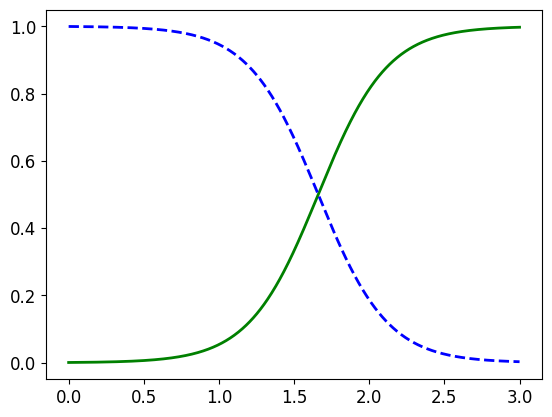

In [40]:
X_new = np.linspace(0, 3, 1000).reshape(1000, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

&#x270b; 아래 코드는 보다 많은 정보를 도표와 함께 전달한다.

- y=1.0를 지난 수평선
- x=1.66 근처의 결정 경계(decision boundary): 검은 수직 점선
- 초록 삼각형: 버지니카 품종
- 파랑 사각형: 버지니카 아닌 품종

그림 저장: logistic_regression_plot


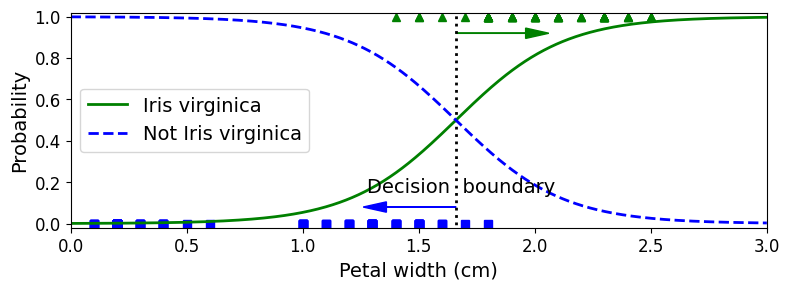

In [41]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary[0], 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

양성 확률이 0.5가 되는 꽃잎 너비의 길이, 즉 결정 경계는 1.66이다. 

In [42]:
decision_boundary

array([1.66066066])

실제로 1.66보다 크면 양성, 작으면 음성으로 판정한다.

In [43]:
log_reg.predict([[1.7], [1.5]])

array([1, 0], dtype=int64)

__예제 2__

아래 코드는 이진 분류 설명을 위해 꽃잎 길이와 너비 두 개의 특성을 이용하여 
버지니카 품종 여부를 판정하는 모델을 훈련한다.

In [44]:
X = iris["data"][:, (2, 3)]                  # 꽃잎 길이와 너비
y = (iris["target"] == 2).astype(np.int64)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=10000000000, random_state=42)

훈련 결과를 도표로 그리면 다음과 같다.

- 검은 실선: 결정 경계
- 다른 직선들: 버지니카(양성) 추정 확률별 결정 경계를 보여줌.

그림 저장: logistic_regression_contour_plot


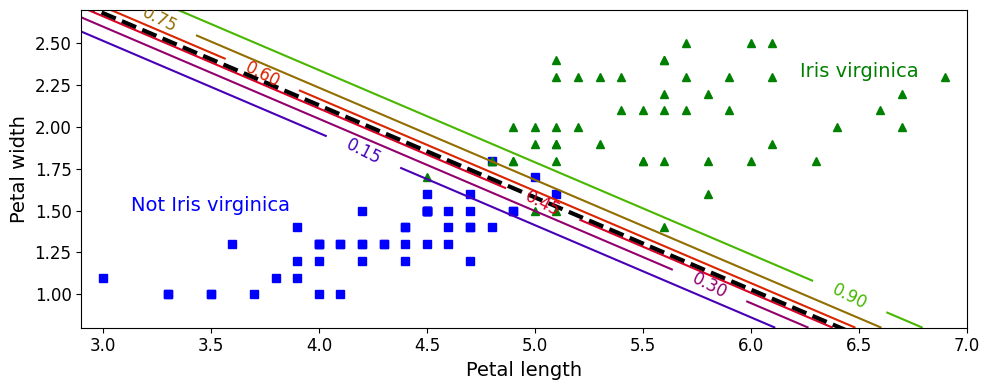

In [45]:
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()